[*********************100%***********************]  2 of 2 completed

Cointegration p-value: 0.7722
Hedge Ratio (β): 0.6368



C:\Users\luvra\AppData\Local\Temp\ipykernel_19064\3809329737.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hedge_ratio = model.params[1]


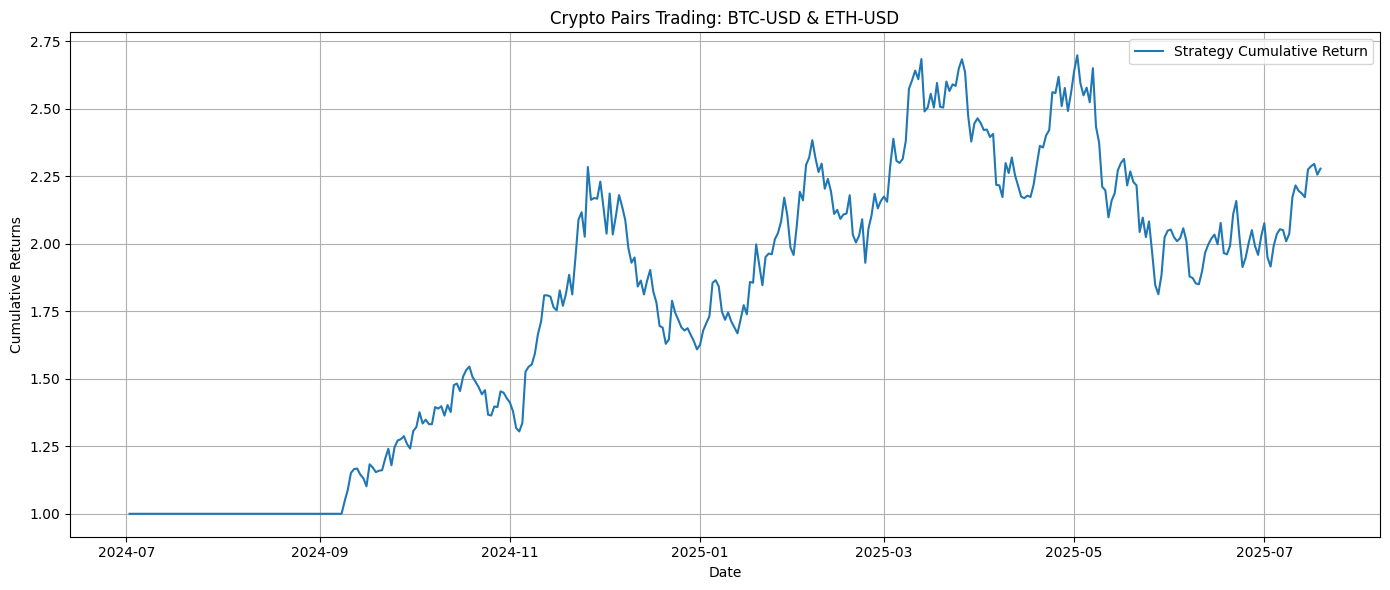

In [10]:
import yfinance as yf
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint
import matplotlib.pyplot as plt

# -----------------------------------
# 1. Define Parameters
# -----------------------------------
tickers = ['INJ-USD', 'AVAX-USD']
start = '2024-07-01'
end = '2025-07-20'

# -----------------------------------
# 2. Fetch Data
# -----------------------------------
data = yf.download(tickers, start=start, end=end, group_by='ticker', interval="1d", auto_adjust=False)
btc = data[tickers[0]]['Close']
eth = data[tickers[1]]['Close']

# Drop NaNs
btc = btc.dropna()
eth = eth.dropna()

# Align indices
btc, eth = btc.align(eth, join='inner')

# -----------------------------------
# 3. Cointegration Test
# -----------------------------------
score, pvalue, _ = coint(btc, eth)
print(f"Cointegration p-value: {pvalue:.4f}")
if pvalue > 0.05:
    print("Warning: No strong cointegration. Pairs trading might not work well.")

# -----------------------------------
# 4. Compute Hedge Ratio
# -----------------------------------
X = sm.add_constant(eth)
model = sm.OLS(btc, X).fit()
hedge_ratio = model.params[1]
print(f"Hedge Ratio (β): {hedge_ratio:.4f}")

# -----------------------------------
# 5. Compute Spread and Z-score
# -----------------------------------
spread = btc - hedge_ratio * eth
rolling_window = 30
zscore = (spread - spread.rolling(rolling_window).mean()) / spread.rolling(rolling_window).std()

# -----------------------------------
# 6. Trading Signals
# -----------------------------------
entry_z = 2
exit_z = 0

signal = pd.Series(index=btc.index, dtype='float64')
signal[zscore > entry_z] = -1     # Short BTC, Long ETH
signal[zscore < -entry_z] = 1     # Long BTC, Short ETH
signal[np.abs(zscore) < exit_z] = 0  # Exit

# Carry forward position until exit
positions = signal.ffill().fillna(0)

# -----------------------------------
# 7. Calculate Strategy Returns
# -----------------------------------
btc_ret = btc.pct_change()
eth_ret = eth.pct_change()
spread_ret = btc_ret - hedge_ratio * eth_ret

strategy_ret = positions.shift(1) * spread_ret
cumulative_ret = (1 + strategy_ret).cumprod()

# -----------------------------------
# 8. Plot Results
# -----------------------------------
plt.figure(figsize=(14, 6))
plt.plot(cumulative_ret, label='Strategy Cumulative Return')
plt.title("Crypto Pairs Trading: BTC-USD & ETH-USD")
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()
